Pointer ε-fact audit (budget-aware, explicit CI):
  n = 10000, pos = 5372, p_hat = 0.5372
  tv_hat = 0.4628, worst-case tv_max = 0.4757
  R_base = 0.0700, ε_target = 0.1000
  CI mode = two-sided, alpha_used = 0.0100
  Licensed? False  (tv_max + R_base ≤ ε_target)


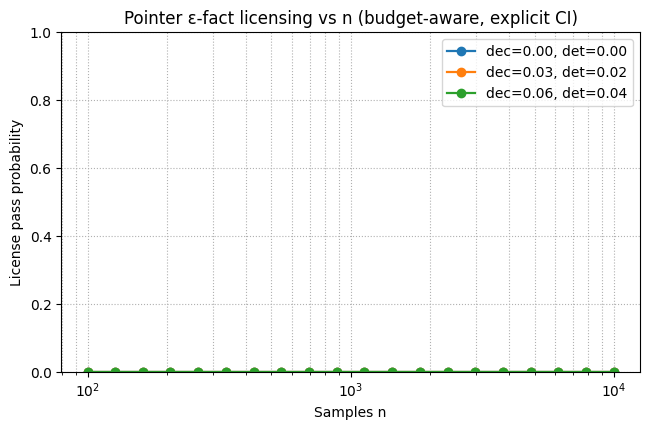


CHSH subcover audit (tight Hoeffding-on-S, equal weights):
  S_hat = 2.826, eps_S = 0.172, dev_sys = 0.560
  Threshold 2 + dev_sys + eps_S = 2.732
  alpha_used = 0.0100, License S > threshold? True

FR audit flow (toy verdict):
FR chain not jointly licensable: inner pointer ε-fact fails.
  Combined confidence (union bound) ≈ 0.970
  Pointer: licensed=False, tv_max=0.489, R_base=0.070, ε_target=0.100
           CI mode=two-sided, alpha_used=0.0100


In [1]:
# FR/Wigner toy audit (FiReal licensing) — explicit tail accounting and CI modes
# - Pointer ε-fact: CP (SciPy) with explicit mode ('two-sided'/'lower'/'upper'); Hoeffding fallback matches mode
# - CHSH subcover: tight Hoeffding-on-S (equal weights), dev_sys = 2·ΣTV_i if per-context budgets, else 8·R_base
# - FR flow: fail-fast on pointer or CHSH obstruction → FR chain not jointly licensable; union-bound confidence
# - Monte Carlo: reuse trials across budgets per n for fairer curves; independent RNG streams

import numpy as np, math, warnings
import matplotlib.pyplot as plt

# Optional SciPy for exact Clopper–Pearson
try:
    from scipy.stats import beta as scipy_beta
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

SEED_BASE = 71237
_WARNED_HOEFFDING_FALLBACK = False  # print warning only once

# ----------------------------- Validation helpers -----------------------------

def clamp_alpha_for_log(alpha):
    """Clamp alpha to (0,1) when used inside log; not used for union-bound summations."""
    return float(max(1e-12, min(1.0 - 1e-12, alpha)))

def ensure_nonneg(x):
    """Clamp a numeric to be nonnegative."""
    return float(max(0.0, x))

def validate_budgets_global(b):
    """Ensure budgets dict has nonnegative, finite entries; clamp negatives and raise on non-finite."""
    keys = ['dec','det','sens','cal','proj']
    out = {}
    for k in keys:
        v = float(b.get(k, 0.0))
        if not np.isfinite(v):
            raise ValueError(f"Budget '{k}' is not finite: {v}")
        if v < 0.0:
            warnings.warn(f"Budget '{k}' is negative ({v}); clamping to 0.0.")
        out[k] = ensure_nonneg(v)
    return out

def validate_budgets_ctx(bctx):
    """
    Validate per-context budgets dict for CHSH contexts (TVs on Z after the fixed pipeline).
    Keys: (0,0),(0,1),(1,0),(1,1). Values must be nonnegative and finite.
    """
    if bctx is None:
        return None
    ctxs = [(0,0),(0,1),(1,0),(1,1)]
    missing = [c for c in ctxs if c not in bctx]
    if missing:
        raise ValueError(f"Per-context budgets missing contexts: {missing}")
    out = {}
    for c in ctxs:
        v = float(bctx[c])
        if not np.isfinite(v):
            raise ValueError(f"Per-context budget {c} is not finite: {v}")
        if v < 0.0:
            warnings.warn(f"Per-context budget {c} is negative ({v}); clamping to 0.0.")
        out[c] = ensure_nonneg(v)
    return out

# ----------------------------- Pointer sampling and bounds -----------------------------

def bernoulli_counts(p, n, rng=None):
    """Sample n Bernoulli(p) draws; return (pos, p_hat)."""
    if rng is None:
        rng = np.random.default_rng()
    n = max(1, int(n))
    x = rng.random(n) < float(p)
    pos = int(x.sum())
    p_hat = float(pos) / float(n)
    return pos, p_hat

def hoeffding_eps_p(n, alpha_total, one_sided=True):
    """
    Hoeffding bound for Bernoulli p:
      - one_sided=True: P(p_hat - p > eps) <= alpha_total
      - one_sided=False: P(|p_hat - p| > eps) <= alpha_total
    """
    n = max(1, int(n))
    a = clamp_alpha_for_log(alpha_total)
    logterm = math.log(1.0 / a) if one_sided else math.log(2.0 / a)
    return math.sqrt(logterm / (2.0 * n))

def cp_bounds(pos, n, alpha_total, mode='two-sided'):
    """
    Clopper–Pearson (or Hoeffding fallback) binomial CI with explicit mode and total failure probability alpha_total.
    Modes:
      - 'two-sided': split alpha_total evenly across tails (alpha_tail = alpha_total/2)
      - 'lower'    : lower one-sided bound at alpha_total; upper = 1.0
      - 'upper'    : upper one-sided bound at (1 - alpha_total); lower = 0.0
    Returns (p_lower, p_upper). Fallback matches the chosen mode.
    """
    n = max(1, int(n))
    alpha_total = float(max(0.0, min(1.0, alpha_total)))
    p_hat = float(pos) / float(n)

    if not SCIPY_AVAILABLE:
        global _WARNED_HOEFFDING_FALLBACK
        if not _WARNED_HOEFFDING_FALLBACK:
            warnings.warn("SciPy not available; fallback to Hoeffding for binomial CI.")
            _WARNED_HOEFFDING_FALLBACK = True
        if mode == 'two-sided':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=False)
            return max(0.0, p_hat - eps), min(1.0, p_hat + eps)
        elif mode == 'lower':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=True)
            return max(0.0, p_hat - eps), 1.0
        elif mode == 'upper':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=True)
            return 0.0, min(1.0, p_hat + eps)
        else:
            raise ValueError("mode must be 'two-sided','lower','upper'")

    # SciPy exact CP
    if mode == 'two-sided':
        a = alpha_total / 2.0
        p_lower = 0.0 if pos <= 0 else scipy_beta.ppf(a, pos, n - pos + 1)
        p_upper = 1.0 if pos >= n else scipy_beta.ppf(1.0 - a, pos + 1, n - pos)
    elif mode == 'lower':
        p_lower = 0.0 if pos <= 0 else scipy_beta.ppf(alpha_total, pos, n - pos + 1)
        p_upper = 1.0
    elif mode == 'upper':
        p_lower = 0.0
        p_upper = 1.0 if pos >= n else scipy_beta.ppf(1.0 - alpha_total, pos + 1, n - pos)
    else:
        raise ValueError("mode must be 'two-sided','lower','upper'")

    # Clamp and enforce ordering
    p_lower = float(max(0.0, min(1.0, p_lower)))
    p_upper = float(max(0.0, min(1.0, p_upper)))
    if (not np.isfinite(p_lower)) or (not np.isfinite(p_upper)) or (p_lower > p_upper):
        mid = max(0.0, min(1.0, p_hat))
        p_lower, p_upper = mid, mid
    return p_lower, p_upper

def tv_max_within_CI(p_lower, p_upper, label='closest'):
    """
    Worst-case TV distance to the claimed label within the CI [p_lower,p_upper].
    - label='ok':    TV = 1 - p ⇒ worst-case 1 - p_lower
    - label='fail':  TV = p     ⇒ worst-case p_upper
    - label='closest' (adaptive): min(p,1-p); worst-case at p_opt = clamp(0.5, [p_lower,p_upper]),
      tv_max = min(p_opt, 1 - p_opt) ≤ 0.5 (exactly 0.5 if CI straddles 0.5).
    """
    p_lower = float(p_lower); p_upper = float(p_upper)
    if label == 'ok':
        return 1.0 - p_lower
    elif label == 'fail':
        return p_upper
    else:
        p_opt = min(max(0.5, p_lower), p_upper)
        return min(p_opt, 1.0 - p_opt)

def eps_fact_license_pointer(pos, n, eps_target, budgets,
                             alpha_stat=0.01, label='closest'):
    """
    Pointer ε-fact (binary) — budget-aware, high-probability license.
    - label='ok'   => mode='lower'  (total failure α_stat used on lower tail)
    - label='fail' => mode='upper'  (total failure α_stat used on upper tail)
    - label='closest' => mode='two-sided' (total failure α_stat split across tails)
    Returns dict with: licensed, tv_hat, tv_max, R_base, p_hat, alpha_used (pointer stage), ci_mode, eps_target.
    """
    n = max(1, int(n))
    budgets = validate_budgets_global(budgets)
    p_hat = float(pos) / float(n)

    if label == 'ok':
        mode = 'lower'
    elif label == 'fail':
        mode = 'upper'
    else:
        mode = 'two-sided'

    p_lower, p_upper = cp_bounds(pos, n, alpha_stat, mode=mode)
    tv_max = tv_max_within_CI(p_lower, p_upper, label=label)
    R_base = budgets['dec'] + budgets['det'] + budgets['sens'] + budgets['cal'] + budgets['proj']
    licensed = (tv_max + R_base) <= float(eps_target)
    tv_hat = min(p_hat, 1.0 - p_hat)

    return dict(
        licensed=licensed,
        tv_hat=tv_hat,
        tv_max=tv_max,
        R_base=R_base,
        p_hat=p_hat,
        alpha_used=float(alpha_stat),
        ci_mode=mode,
        eps_target=float(eps_target)
    )

# ----------------------------- Pointer demo and sweep -----------------------------

bud_pointer = dict(dec=0.03, det=0.02, sens=0.01, cal=0.01, proj=0.00)  # proj only if ND justified
p0 = 0.53
n_ptr = 10_000
alpha_stat = 0.01
eps_target = 0.10

# Single run
rng_ptr = np.random.default_rng(SEED_BASE)
pos, p_hat = bernoulli_counts(p0, n_ptr, rng=rng_ptr)
res_ptr = eps_fact_license_pointer(pos, n_ptr, eps_target, budgets=bud_pointer, alpha_stat=alpha_stat, label='closest')

print("Pointer ε-fact audit (budget-aware, explicit CI):")
print(f"  n = {n_ptr}, pos = {pos}, p_hat = {p_hat:.4f}")
print(f"  tv_hat = {res_ptr['tv_hat']:.4f}, worst-case tv_max = {res_ptr['tv_max']:.4f}")
print(f"  R_base = {res_ptr['R_base']:.4f}, ε_target = {res_ptr['eps_target']:.4f}")
print(f"  CI mode = {res_ptr['ci_mode']}, alpha_used = {res_ptr['alpha_used']:.4f}")
print(f"  Licensed? {res_ptr['licensed']}  (tv_max + R_base ≤ ε_target)")

def sweep_pointer(p0, eps_target, N_vec, budgets_list, alpha_stat=0.01, trials=500, seed_base=777):
    """
    Pass probability across (budget, n). Reuse the same trials across budgets per n for fair comparison.
    """
    HM = np.zeros((len(budgets_list), len(N_vec)), dtype=float)
    for j, n in enumerate(N_vec):
        rng_n = np.random.default_rng(seed_base + j)
        # Reuse the same trials across budgets
        pos_trials = rng_n.binomial(int(n), float(p0), size=int(trials))
        for i, b in enumerate(budgets_list):
            hits = 0
            for pos in pos_trials:
                lic = eps_fact_license_pointer(pos, int(n), eps_target, budgets=b, alpha_stat=alpha_stat, label='closest')['licensed']
                hits += int(lic)
            HM[i, j] = hits / float(trials)
    return HM

budgets_list = [
    dict(dec=0.00, det=0.00, sens=0.00, cal=0.00, proj=0.00),
    dict(dec=0.03, det=0.02, sens=0.00, cal=0.00, proj=0.00),
    dict(dec=0.06, det=0.04, sens=0.00, cal=0.00, proj=0.00),
]
N_vec = np.unique((np.logspace(2, 4, 20)).astype(int))

HM = sweep_pointer(p0, eps_target, N_vec, budgets_list, alpha_stat=alpha_stat, trials=500, seed_base=911)

plt.figure(figsize=(6.6,4.4))
for i, b in enumerate(budgets_list):
    label = f"dec={b['dec']:.02f}, det={b['det']:.02f}"
    plt.plot(N_vec, HM[i, :], marker='o', lw=1.6, label=label)
plt.xscale('log'); plt.ylim(0,1)
plt.xlabel('Samples n'); plt.ylabel('License pass probability')
plt.title('Pointer ε-fact licensing vs n (budget-aware, explicit CI)')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------- CHSH subcover (tight S-level bound) -----------------------------

def Es_tsirelson():
    return {(0,0):  1/np.sqrt(2),
            (0,1):  1/np.sqrt(2),
            (1,0):  1/np.sqrt(2),
            (1,1): -1/np.sqrt(2)}

def sample_chsh_counts(nc, Es=None, rng=None):
    """
    Sample per-context ±1 outcomes with P(ab=+1)=(1+E)/2; return Shat and n_vec.
    Standard equal-weights CHSH: S = E00 + E01 + E10 - E11.
    """
    if rng is None:
        rng = np.random.default_rng()
    if Es is None:
        Es = Es_tsirelson()
    Ehat = np.zeros(4, dtype=float)
    n_vec = np.array(nc, dtype=int)
    ctxs = [(0,0),(0,1),(1,0),(1,1)]
    for i, (x,y) in enumerate(ctxs):
        n = int(n_vec[i])
        if n <= 0:
            Ehat[i] = 0.0
            continue
        p_plus = (1.0 + Es[(x,y)]) / 2.0
        ab_plus = rng.random(n) < p_plus
        Ehat[i] = 2.0 * ab_plus.mean() - 1.0
    Shat = Ehat[0] + Ehat[1] + Ehat[2] - Ehat[3]
    return Shat, n_vec

def hoeffding_eps_S(n_vec, alpha_total, one_sided=True):
    """
    Hoeffding bound on S (equal-weights CHSH).
    - one_sided=True: eps_S = sqrt( 2 ln(1/α_total) * Σ_i 1/n_i )
    - one_sided=False: eps_S = sqrt( 2 ln(2/α_total) * Σ_i 1/n_i )
    """
    n_vec = np.maximum(1, np.array(n_vec, dtype=float))
    a = clamp_alpha_for_log(alpha_total)
    s = float(np.sum(1.0 / n_vec))
    logterm = math.log(1.0 / a) if one_sided else math.log(2.0 / a)
    return math.sqrt(2.0 * s * logterm)

def compute_dev_sys_equal_weights(budgets_global, budgets_ctx=None):
    """
    Systematic deviation bound on S for equal-weights CHSH.
    - If per-context budgets are provided (post-pipeline TVs), dev_sys = 2 · Σ TV_i.
    - Else, if only the average TV budget R_base is known under uniform settings (Σ (1/4) TV_i ≤ R_base),
      then Σ TV_i ≤ 4 R_base and |ΔS| ≤ Σ |ΔE_i| ≤ 2 Σ TV_i ⇒ dev_sys ≤ 8 R_base.
      Assumption: settings are uniformly sampled; R_base is a bound on the average per-context TV.
    """
    b = validate_budgets_global(budgets_global)
    R_base = b['dec'] + b['det'] + b['sens'] + b['cal'] + b['proj']

    bctx = validate_budgets_ctx(budgets_ctx)
    if bctx is not None:
        TV_sum = float(sum(bctx[c] for c in [(0,0),(0,1),(1,0),(1,1)]))
        return 2.0 * TV_sum
    else:
        return 8.0 * R_base

def chsh_license_tight_S(N, budgets_global, budgets_ctx=None, alpha=0.01, min_n_per_ctx=5, two_sided=False, rng=None):
    """
    CHSH audit via direct Hoeffding-on-S (tight, distribution-free), equal-weights S.
    - Equal allocation minimizes Σ_i 1/n_i subject to Σ n_i = N.
    - dev_sys via compute_dev_sys_equal_weights.
    - One-sided license: Shat > 2 + dev_sys + eps_S (α used here is the total tail probability).
    Returns dict with: S, n_vec, eps_S, dev_sys, threshold, passes, alpha_used.
    """
    if rng is None:
        rng = np.random.default_rng()
    C = 4
    min_total = C * int(min_n_per_ctx)
    if N < min_total:
        raise ValueError(f"N={N} too small for {C} contexts with min_n_per_ctx={min_n_per_ctx} (need ≥ {min_total}).")

    # Equal allocation
    base = max(int(min_n_per_ctx), int(N // C))
    n_vec = np.full(C, base, dtype=int)
    diff = int(N) - int(n_vec.sum())
    for i in range(abs(diff)):
        n_vec[i % C] += 1 if diff > 0 else -1

    Shat, n_vec = sample_chsh_counts(n_vec, Es=Es_tsirelson(), rng=rng)
    eps_S = hoeffding_eps_S(n_vec, alpha_total=alpha, one_sided=not two_sided)
    dev_sys = compute_dev_sys_equal_weights(budgets_global, budgets_ctx=budgets_ctx)

    threshold = 2.0 + dev_sys + eps_S
    passes = (Shat > threshold) if not two_sided else (abs(Shat) > threshold)

    return dict(S=Shat, n_vec=n_vec, eps_S=eps_S, dev_sys=dev_sys, threshold=threshold, passes=passes, alpha_used=float(alpha))

# Quick CHSH verdict (ND justified case)
N_chsh = 5000
bud_chsh = dict(dec=0.05, det=0.02, sens=0.00, cal=0.00, proj=0.00)
budgets_ctx = None  # set per-context budgets for tighter dev_sys, e.g., {(0,0):0.03,(0,1):0.02,(1,0):0.01,(1,1):0.01}

rng_chsh = np.random.default_rng(SEED_BASE + 101)
res_chsh = chsh_license_tight_S(N_chsh, budgets_global=bud_chsh, budgets_ctx=budgets_ctx,
                                alpha=0.01, min_n_per_ctx=5, two_sided=False, rng=rng_chsh)

print("\nCHSH subcover audit (tight Hoeffding-on-S, equal weights):")
print(f"  S_hat = {res_chsh['S']:.3f}, eps_S = {res_chsh['eps_S']:.3f}, dev_sys = {res_chsh['dev_sys']:.3f}")
print(f"  Threshold 2 + dev_sys + eps_S = {res_chsh['threshold']:.3f}")
print(f"  alpha_used = {res_chsh['alpha_used']:.4f}, License S > threshold? {res_chsh['passes']}")

# ----------------------------- FR audit flow (toy) -----------------------------

def fr_audit_flow(p0, n_pointer, eps_target_pointer, budgets_pointer,
                  N_chsh, budgets_chsh, budgets_chsh_ctx=None,
                  alpha_stat=0.01, alpha_chsh=0.01, alpha_dec=0.0, alpha_det=0.0,
                  label='closest', rng=None):
    """
    FR audit logic: either the inner pointer ε-fact fails (no audit path), or CHSH obstructs gluing.
    Returns dict with pointer, chsh, verdict, and overall confidence via a union bound on the tails used.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Pointer stage
    pos, p_hat = bernoulli_counts(p0, n_pointer, rng=rng)
    ptr = eps_fact_license_pointer(pos, n_pointer, eps_target_pointer, budgets_pointer,
                                   alpha_stat=alpha_stat, label=label)

    # If pointer ε-fact fails: FR chain already lacks a finite audit path
    if not ptr['licensed']:
        alpha_total = float(ptr['alpha_used']) + float(alpha_dec or 0.0) + float(alpha_det or 0.0)
        confidence = max(0.0, 1.0 - min(1.0, alpha_total))
        verdict = "FR chain not jointly licensable: inner pointer ε-fact fails."
        return dict(pointer=ptr, chsh=None, verdict=verdict, confidence=confidence)

    # CHSH stage (outer agents)
    ch = chsh_license_tight_S(N_chsh, budgets_global=budgets_chsh, budgets_ctx=budgets_chsh_ctx,
                              alpha=alpha_chsh, min_n_per_ctx=5, two_sided=False, rng=np.random.default_rng(SEED_BASE + 202))

    if ch['passes']:
        verdict = "FR chain not jointly licensable: robust CHSH obstruction to gluing."
    else:
        verdict = "Inconclusive in this toy run (pointer licensed, CHSH obstruction not certified at chosen budgets/N)."

    # Overall confidence via union bound across pointer, CHSH, and calibration tails
    alpha_total = float(ptr['alpha_used']) + float(ch['alpha_used']) + float(alpha_dec or 0.0) + float(alpha_det or 0.0)
    confidence = max(0.0, 1.0 - min(1.0, alpha_total))

    return dict(pointer=ptr, chsh=ch, verdict=verdict, confidence=confidence)

# Run the FR audit flow (toy)
rng_fr = np.random.default_rng(SEED_BASE + 303)
res_fr = fr_audit_flow(
    p0=0.53, n_pointer=n_ptr, eps_target_pointer=eps_target, budgets_pointer=bud_pointer,
    N_chsh=N_chsh, budgets_chsh=bud_chsh, budgets_chsh_ctx=budgets_ctx,
    alpha_stat=0.01, alpha_chsh=0.01, alpha_dec=0.01, alpha_det=0.01,  # placeholders for calibration tails
    label='closest', rng=rng_fr
)

print("\nFR audit flow (toy verdict):")
print(res_fr['verdict'])
print(f"  Combined confidence (union bound) ≈ {res_fr['confidence']:.3f}")
if res_fr['pointer'] is not None:
    p = res_fr['pointer']
    print(f"  Pointer: licensed={p['licensed']}, tv_max={p['tv_max']:.3f}, R_base={p['R_base']:.3f}, ε_target={p['eps_target']:.3f}")
    print(f"           CI mode={p['ci_mode']}, alpha_used={p['alpha_used']:.4f}")
if res_fr['chsh'] is not None:
    c = res_fr['chsh']
    print(f"  CHSH:    S_hat={c['S']:.3f}, threshold={c['threshold']:.3f}, passes={c['passes']}, alpha_used={c['alpha_used']:.4f}")

Pointer ε-fact audit (budget-aware, explicit CI):
  n = 10000, pos = 5372, p_hat = 0.5372
  tv_hat = 0.4628, worst-case tv_max = 0.4757
  R_base = 0.0700, ε_target = 0.1000
  CI mode = two-sided, alpha_used = 0.0100
  Licensed? False  (tv_max + R_base ≤ ε_target)


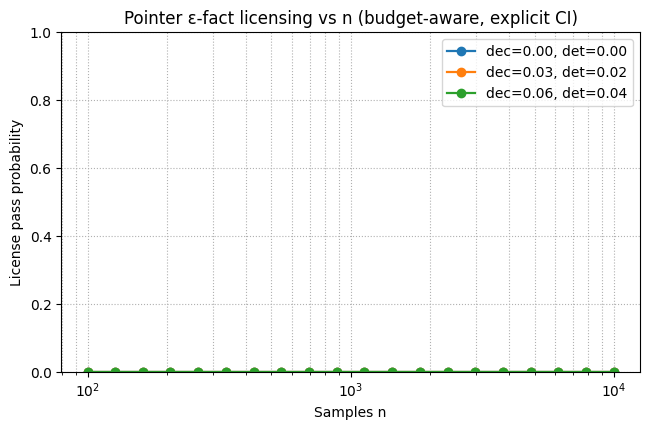

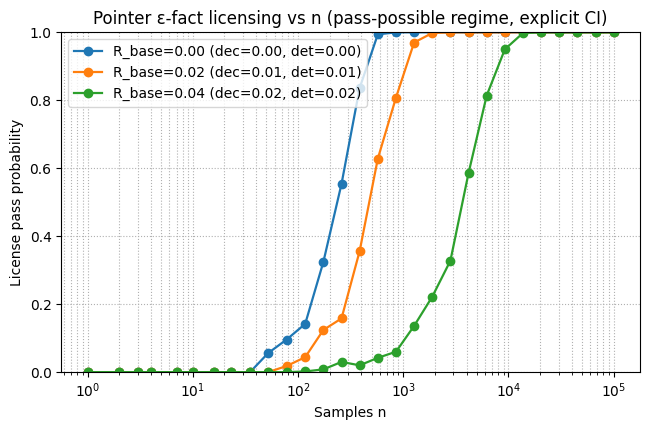


CHSH subcover audit (tight Hoeffding-on-S, equal weights):
  S_hat = 2.826, eps_S = 0.172, dev_sys = 0.560
  Threshold 2 + dev_sys + eps_S = 2.732
  alpha_used = 0.0100, License S > threshold? True

FR audit flow (toy verdict):
FR chain not jointly licensable: inner pointer ε-fact fails.
  Combined confidence (union bound) ≈ 0.970
  Pointer: licensed=False, tv_max=0.489, R_base=0.070, ε_target=0.100
           CI mode=two-sided, alpha_used=0.0100


In [1]:
# FR/Wigner toy audit (FiReal licensing) — explicit tail accounting and CI modes
# - Pointer ε-fact: CP (SciPy) with explicit mode ('two-sided'/'lower'/'upper'); Hoeffding fallback matches mode
# - CHSH subcover: tight Hoeffding-on-S (equal weights), dev_sys = 2·ΣTV_i if per-context budgets, else 8·R_base
# - FR flow: fail-fast on pointer or CHSH obstruction → FR chain not jointly licensable; union-bound confidence
# - Monte Carlo: reuse trials across budgets per n for fairer curves; independent RNG streams

import numpy as np, math, warnings
import matplotlib.pyplot as plt

# Optional SciPy for exact Clopper–Pearson
try:
    from scipy.stats import beta as scipy_beta
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

SEED_BASE = 71237
_WARNED_HOEFFDING_FALLBACK = False  # print warning only once

# ----------------------------- Validation helpers -----------------------------

def clamp_alpha_for_log(alpha):
    """Clamp alpha to (0,1) when used inside log; not used for union-bound summations."""
    return float(max(1e-12, min(1.0 - 1e-12, alpha)))

def ensure_nonneg(x):
    """Clamp a numeric to be nonnegative."""
    return float(max(0.0, x))

def validate_budgets_global(b):
    """Ensure budgets dict has nonnegative, finite entries; clamp negatives and raise on non-finite."""
    keys = ['dec','det','sens','cal','proj']
    out = {}
    for k in keys:
        v = float(b.get(k, 0.0))
        if not np.isfinite(v):
            raise ValueError(f"Budget '{k}' is not finite: {v}")
        if v < 0.0:
            warnings.warn(f"Budget '{k}' is negative ({v}); clamping to 0.0.")
        out[k] = ensure_nonneg(v)
    return out

def validate_budgets_ctx(bctx):
    """
    Validate per-context budgets dict for CHSH contexts (TVs on Z after the fixed pipeline).
    Keys: (0,0),(0,1),(1,0),(1,1). Values must be nonnegative and finite.
    """
    if bctx is None:
        return None
    ctxs = [(0,0),(0,1),(1,0),(1,1)]
    missing = [c for c in ctxs if c not in bctx]
    if missing:
        raise ValueError(f"Per-context budgets missing contexts: {missing}")
    out = {}
    for c in ctxs:
        v = float(bctx[c])
        if not np.isfinite(v):
            raise ValueError(f"Per-context budget {c} is not finite: {v}")
        if v < 0.0:
            warnings.warn(f"Per-context budget {c} is negative ({v}); clamping to 0.0.")
        out[c] = ensure_nonneg(v)
    return out

# ----------------------------- Pointer sampling and bounds -----------------------------

def bernoulli_counts(p, n, rng=None):
    """Sample n Bernoulli(p) draws; return (pos, p_hat)."""
    if rng is None:
        rng = np.random.default_rng()
    n = max(1, int(n))
    x = rng.random(n) < float(p)
    pos = int(x.sum())
    p_hat = float(pos) / float(n)
    return pos, p_hat

def hoeffding_eps_p(n, alpha_total, one_sided=True):
    """
    Hoeffding bound for Bernoulli p:
      - one_sided=True: P(p_hat - p > eps) <= alpha_total
      - one_sided=False: P(|p_hat - p| > eps) <= alpha_total
    """
    n = max(1, int(n))
    a = clamp_alpha_for_log(alpha_total)
    logterm = math.log(1.0 / a) if one_sided else math.log(2.0 / a)
    return math.sqrt(logterm / (2.0 * n))

def cp_bounds(pos, n, alpha_total, mode='two-sided'):
    """
    Clopper–Pearson (or Hoeffding fallback) binomial CI with explicit mode and total failure probability alpha_total.
    Modes:
      - 'two-sided': split alpha_total evenly across tails (alpha_tail = alpha_total/2)
      - 'lower'    : lower one-sided bound at alpha_total; upper = 1.0
      - 'upper'    : upper one-sided bound at (1 - alpha_total); lower = 0.0
    Returns (p_lower, p_upper). Fallback matches the chosen mode.
    """
    n = max(1, int(n))
    alpha_total = float(max(0.0, min(1.0, alpha_total)))
    p_hat = float(pos) / float(n)

    if not SCIPY_AVAILABLE:
        global _WARNED_HOEFFDING_FALLBACK
        if not _WARNED_HOEFFDING_FALLBACK:
            warnings.warn("SciPy not available; fallback to Hoeffding for binomial CI.")
            _WARNED_HOEFFDING_FALLBACK = True
        if mode == 'two-sided':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=False)
            return max(0.0, p_hat - eps), min(1.0, p_hat + eps)
        elif mode == 'lower':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=True)
            return max(0.0, p_hat - eps), 1.0
        elif mode == 'upper':
            eps = hoeffding_eps_p(n, alpha_total, one_sided=True)
            return 0.0, min(1.0, p_hat + eps)
        else:
            raise ValueError("mode must be 'two-sided','lower','upper'")

    # SciPy exact CP
    if mode == 'two-sided':
        a = alpha_total / 2.0
        p_lower = 0.0 if pos <= 0 else scipy_beta.ppf(a, pos, n - pos + 1)
        p_upper = 1.0 if pos >= n else scipy_beta.ppf(1.0 - a, pos + 1, n - pos)
    elif mode == 'lower':
        p_lower = 0.0 if pos <= 0 else scipy_beta.ppf(alpha_total, pos, n - pos + 1)
        p_upper = 1.0
    elif mode == 'upper':
        p_lower = 0.0
        p_upper = 1.0 if pos >= n else scipy_beta.ppf(1.0 - alpha_total, pos + 1, n - pos)
    else:
        raise ValueError("mode must be 'two-sided','lower','upper'")

    # Clamp and enforce ordering
    p_lower = float(max(0.0, min(1.0, p_lower)))
    p_upper = float(max(0.0, min(1.0, p_upper)))
    if (not np.isfinite(p_lower)) or (not np.isfinite(p_upper)) or (p_lower > p_upper):
        mid = max(0.0, min(1.0, p_hat))
        p_lower, p_upper = mid, mid
    return p_lower, p_upper

def tv_max_within_CI(p_lower, p_upper, label='closest'):
    """
    Worst-case TV distance to the claimed label within the CI [p_lower,p_upper].
    - label='ok':    TV = 1 - p ⇒ worst-case 1 - p_lower
    - label='fail':  TV = p     ⇒ worst-case p_upper
    - label='closest' (adaptive): min(p,1-p); worst-case at p_opt = clamp(0.5, [p_lower,p_upper]),
      tv_max = min(p_opt, 1 - p_opt) ≤ 0.5 (exactly 0.5 if CI straddles 0.5).
    """
    p_lower = float(p_lower); p_upper = float(p_upper)
    if label == 'ok':
        return 1.0 - p_lower
    elif label == 'fail':
        return p_upper
    else:
        p_opt = min(max(0.5, p_lower), p_upper)
        return min(p_opt, 1.0 - p_opt)

def eps_fact_license_pointer(pos, n, eps_target, budgets,
                             alpha_stat=0.01, label='closest'):
    """
    Pointer ε-fact (binary) — budget-aware, high-probability license.
    - label='ok'   => mode='lower'  (total failure α_stat used on lower tail)
    - label='fail' => mode='upper'  (total failure α_stat used on upper tail)
    - label='closest' => mode='two-sided' (total failure α_stat split across tails)
    Returns dict with: licensed, tv_hat, tv_max, R_base, p_hat, alpha_used (pointer stage), ci_mode, eps_target.
    """
    n = max(1, int(n))
    budgets = validate_budgets_global(budgets)
    p_hat = float(pos) / float(n)

    if label == 'ok':
        mode = 'lower'
    elif label == 'fail':
        mode = 'upper'
    else:
        mode = 'two-sided'

    p_lower, p_upper = cp_bounds(pos, n, alpha_stat, mode=mode)
    tv_max = tv_max_within_CI(p_lower, p_upper, label=label)
    R_base = budgets['dec'] + budgets['det'] + budgets['sens'] + budgets['cal'] + budgets['proj']
    licensed = (tv_max + R_base) <= float(eps_target)
    tv_hat = min(p_hat, 1.0 - p_hat)

    return dict(
        licensed=licensed,
        tv_hat=tv_hat,
        tv_max=tv_max,
        R_base=R_base,
        p_hat=p_hat,
        alpha_used=float(alpha_stat),
        ci_mode=mode,
        eps_target=float(eps_target)
    )

# ----------------------------- Pointer demo and sweep -----------------------------

bud_pointer = dict(dec=0.03, det=0.02, sens=0.01, cal=0.01, proj=0.00)  # proj only if ND justified
p0 = 0.53
n_ptr = 10_000
alpha_stat = 0.01
eps_target = 0.10

# Single run
rng_ptr = np.random.default_rng(SEED_BASE)
pos, p_hat = bernoulli_counts(p0, n_ptr, rng=rng_ptr)
res_ptr = eps_fact_license_pointer(pos, n_ptr, eps_target, budgets=bud_pointer, alpha_stat=alpha_stat, label='closest')

print("Pointer ε-fact audit (budget-aware, explicit CI):")
print(f"  n = {n_ptr}, pos = {pos}, p_hat = {p_hat:.4f}")
print(f"  tv_hat = {res_ptr['tv_hat']:.4f}, worst-case tv_max = {res_ptr['tv_max']:.4f}")
print(f"  R_base = {res_ptr['R_base']:.4f}, ε_target = {res_ptr['eps_target']:.4f}")
print(f"  CI mode = {res_ptr['ci_mode']}, alpha_used = {res_ptr['alpha_used']:.4f}")
print(f"  Licensed? {res_ptr['licensed']}  (tv_max + R_base ≤ ε_target)")

def sweep_pointer(p0, eps_target, N_vec, budgets_list, alpha_stat=0.01, trials=500, seed_base=777):
    """
    Pass probability across (budget, n). Reuse the same trials across budgets per n for fair comparison.
    """
    HM = np.zeros((len(budgets_list), len(N_vec)), dtype=float)
    for j, n in enumerate(N_vec):
        rng_n = np.random.default_rng(seed_base + j)
        # Reuse the same trials across budgets
        pos_trials = rng_n.binomial(int(n), float(p0), size=int(trials))
        for i, b in enumerate(budgets_list):
            hits = 0
            for pos in pos_trials:
                lic = eps_fact_license_pointer(pos, int(n), eps_target, budgets=b, alpha_stat=alpha_stat, label='closest')['licensed']
                hits += int(lic)
            HM[i, j] = hits / float(trials)
    return HM

budgets_list = [
    dict(dec=0.00, det=0.00, sens=0.00, cal=0.00, proj=0.00),
    dict(dec=0.03, det=0.02, sens=0.00, cal=0.00, proj=0.00),
    dict(dec=0.06, det=0.04, sens=0.00, cal=0.00, proj=0.00),
]
N_vec = np.unique((np.logspace(2, 4, 20)).astype(int))

HM = sweep_pointer(p0, eps_target, N_vec, budgets_list, alpha_stat=alpha_stat, trials=500, seed_base=911)

plt.figure(figsize=(6.6,4.4))
for i, b in enumerate(budgets_list):
    label = f"dec={b['dec']:.02f}, det={b['det']:.02f}"
    plt.plot(N_vec, HM[i, :], marker='o', lw=1.6, label=label)
plt.xscale('log'); plt.ylim(0,1)
plt.xlabel('Samples n'); plt.ylabel('License pass probability')
plt.title('Pointer ε-fact licensing vs n (budget-aware, explicit CI)')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------- Pointer S-curve regime (pass becomes possible) -----------------------------
# Parameters for pass-possible regime: p0 far from 0.5 so asymptotic tv_max is small,
# eps_target > asymptotic tv_max + R_base, but < 0.5 + R_base for initial impossibility at small n.
p0_pass = 0.95  # Asymptotic tv_max ~ min(0.95, 0.05) = 0.05
eps_target_pass = 0.10  # > 0.05 + max R_base (0.04) = 0.09, but < 0.5 + min R_base (0.0) = 0.5
alpha_stat_pass = 0.01  # Same as before
trials_pass = 500  # Same
seed_base_pass = 911  # Same for reproducibility

budgets_list_pass = [
    dict(dec=0.00, det=0.00, sens=0.00, cal=0.00, proj=0.00),  # R_base=0.00, asymptotic 0.05 + 0.00 = 0.05 < 0.10
    dict(dec=0.01, det=0.01, sens=0.00, cal=0.00, proj=0.00),  # R_base=0.02, asymptotic 0.05 + 0.02 = 0.07 < 0.10
    dict(dec=0.02, det=0.02, sens=0.00, cal=0.00, proj=0.00),  # R_base=0.04, asymptotic 0.05 + 0.04 = 0.09 < 0.10
]

# Wider n range to capture the S-curve transition (from impossible at small n to certain pass at large n)
N_vec_pass = np.unique(np.logspace(0, 5, 30).astype(int))  # From ~1 to 100k

HM_pass = sweep_pointer(p0_pass, eps_target_pass, N_vec_pass, budgets_list_pass,
                        alpha_stat=alpha_stat_pass, trials=trials_pass, seed_base=seed_base_pass)

plt.figure(figsize=(6.6,4.4))
for i, b in enumerate(budgets_list_pass):
    R_base = b['dec'] + b['det'] + b['sens'] + b['cal'] + b['proj']
    label = f"R_base={R_base:.02f} (dec={b['dec']:.02f}, det={b['det']:.02f})"
    plt.plot(N_vec_pass, HM_pass[i, :], marker='o', lw=1.6, label=label)
plt.xscale('log'); plt.ylim(0,1)
plt.xlabel('Samples n'); plt.ylabel('License pass probability')
plt.title('Pointer ε-fact licensing vs n (pass-possible regime, explicit CI)')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------- CHSH subcover (tight S-level bound) -----------------------------

def Es_tsirelson():
    return {(0,0):  1/np.sqrt(2),
            (0,1):  1/np.sqrt(2),
            (1,0):  1/np.sqrt(2),
            (1,1): -1/np.sqrt(2)}

def sample_chsh_counts(nc, Es=None, rng=None):
    """
    Sample per-context ±1 outcomes with P(ab=+1)=(1+E)/2; return Shat and n_vec.
    Standard equal-weights CHSH: S = E00 + E01 + E10 - E11.
    """
    if rng is None:
        rng = np.random.default_rng()
    if Es is None:
        Es = Es_tsirelson()
    Ehat = np.zeros(4, dtype=float)
    n_vec = np.array(nc, dtype=int)
    ctxs = [(0,0),(0,1),(1,0),(1,1)]
    for i, (x,y) in enumerate(ctxs):
        n = int(n_vec[i])
        if n <= 0:
            Ehat[i] = 0.0
            continue
        p_plus = (1.0 + Es[(x,y)]) / 2.0
        ab_plus = rng.random(n) < p_plus
        Ehat[i] = 2.0 * ab_plus.mean() - 1.0
    Shat = Ehat[0] + Ehat[1] + Ehat[2] - Ehat[3]
    return Shat, n_vec

def hoeffding_eps_S(n_vec, alpha_total, one_sided=True):
    """
    Hoeffding bound on S (equal-weights CHSH).
    - one_sided=True: eps_S = sqrt( 2 ln(1/α_total) * Σ_i 1/n_i )
    - one_sided=False: eps_S = sqrt( 2 ln(2/α_total) * Σ_i 1/n_i )
    """
    n_vec = np.maximum(1, np.array(n_vec, dtype=float))
    a = clamp_alpha_for_log(alpha_total)
    s = float(np.sum(1.0 / n_vec))
    logterm = math.log(1.0 / a) if one_sided else math.log(2.0 / a)
    return math.sqrt(2.0 * s * logterm)

def compute_dev_sys_equal_weights(budgets_global, budgets_ctx=None):
    """
    Systematic deviation bound on S for equal-weights CHSH.
    - If per-context budgets are provided (post-pipeline TVs), dev_sys = 2 · Σ TV_i.
    - Else, if only the average TV budget R_base is known under uniform settings (Σ (1/4) TV_i ≤ R_base),
      then Σ TV_i ≤ 4 R_base and |ΔS| ≤ Σ |ΔE_i| ≤ 2 Σ TV_i ⇒ dev_sys ≤ 8 R_base.
      Assumption: settings are uniformly sampled; R_base is a bound on the average per-context TV.
    """
    b = validate_budgets_global(budgets_global)
    R_base = b['dec'] + b['det'] + b['sens'] + b['cal'] + b['proj']

    bctx = validate_budgets_ctx(budgets_ctx)
    if bctx is not None:
        TV_sum = float(sum(bctx[c] for c in [(0,0),(0,1),(1,0),(1,1)]))
        return 2.0 * TV_sum
    else:
        return 8.0 * R_base

def chsh_license_tight_S(N, budgets_global, budgets_ctx=None, alpha=0.01, min_n_per_ctx=5, two_sided=False, rng=None):
    """
    CHSH audit via direct Hoeffding-on-S (tight, distribution-free), equal-weights S.
    - Equal allocation minimizes Σ_i 1/n_i subject to Σ n_i = N.
    - dev_sys via compute_dev_sys_equal_weights.
    - One-sided license: Shat > 2 + dev_sys + eps_S (α used here is the total tail probability).
    Returns dict with: S, n_vec, eps_S, dev_sys, threshold, passes, alpha_used.
    """
    if rng is None:
        rng = np.random.default_rng()
    C = 4
    min_total = C * int(min_n_per_ctx)
    if N < min_total:
        raise ValueError(f"N={N} too small for {C} contexts with min_n_per_ctx={min_n_per_ctx} (need ≥ {min_total}).")

    # Equal allocation
    base = max(int(min_n_per_ctx), int(N // C))
    n_vec = np.full(C, base, dtype=int)
    diff = int(N) - int(n_vec.sum())
    for i in range(abs(diff)):
        n_vec[i % C] += 1 if diff > 0 else -1

    Shat, n_vec = sample_chsh_counts(n_vec, Es=Es_tsirelson(), rng=rng)
    eps_S = hoeffding_eps_S(n_vec, alpha_total=alpha, one_sided=not two_sided)
    dev_sys = compute_dev_sys_equal_weights(budgets_global, budgets_ctx=budgets_ctx)

    threshold = 2.0 + dev_sys + eps_S
    passes = (Shat > threshold) if not two_sided else (abs(Shat) > threshold)

    return dict(S=Shat, n_vec=n_vec, eps_S=eps_S, dev_sys=dev_sys, threshold=threshold, passes=passes, alpha_used=float(alpha))

# Quick CHSH verdict (ND justified case)
N_chsh = 5000
bud_chsh = dict(dec=0.05, det=0.02, sens=0.00, cal=0.00, proj=0.00)
budgets_ctx = None  # set per-context budgets for tighter dev_sys, e.g., {(0,0):0.03,(0,1):0.02,(1,0):0.01,(1,1):0.01}

rng_chsh = np.random.default_rng(SEED_BASE + 101)
res_chsh = chsh_license_tight_S(N_chsh, budgets_global=bud_chsh, budgets_ctx=budgets_ctx,
                                alpha=0.01, min_n_per_ctx=5, two_sided=False, rng=rng_chsh)

print("\nCHSH subcover audit (tight Hoeffding-on-S, equal weights):")
print(f"  S_hat = {res_chsh['S']:.3f}, eps_S = {res_chsh['eps_S']:.3f}, dev_sys = {res_chsh['dev_sys']:.3f}")
print(f"  Threshold 2 + dev_sys + eps_S = {res_chsh['threshold']:.3f}")
print(f"  alpha_used = {res_chsh['alpha_used']:.4f}, License S > threshold? {res_chsh['passes']}")

# ----------------------------- FR audit flow (toy) -----------------------------

def fr_audit_flow(p0, n_pointer, eps_target_pointer, budgets_pointer,
                  N_chsh, budgets_chsh, budgets_chsh_ctx=None,
                  alpha_stat=0.01, alpha_chsh=0.01, alpha_dec=0.0, alpha_det=0.0,
                  label='closest', rng=None):
    """
    FR audit logic: either the inner pointer ε-fact fails (no audit path), or CHSH obstructs gluing.
    Returns dict with pointer, chsh, verdict, and overall confidence via a union bound on the tails used.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Pointer stage
    pos, p_hat = bernoulli_counts(p0, n_pointer, rng=rng)
    ptr = eps_fact_license_pointer(pos, n_pointer, eps_target_pointer, budgets_pointer,
                                   alpha_stat=alpha_stat, label=label)

    # If pointer ε-fact fails: FR chain already lacks a finite audit path
    if not ptr['licensed']:
        alpha_total = float(ptr['alpha_used']) + float(alpha_dec or 0.0) + float(alpha_det or 0.0)
        confidence = max(0.0, 1.0 - min(1.0, alpha_total))
        verdict = "FR chain not jointly licensable: inner pointer ε-fact fails."
        return dict(pointer=ptr, chsh=None, verdict=verdict, confidence=confidence)

    # CHSH stage (outer agents)
    ch = chsh_license_tight_S(N_chsh, budgets_global=budgets_chsh, budgets_ctx=budgets_chsh_ctx,
                              alpha=alpha_chsh, min_n_per_ctx=5, two_sided=False, rng=np.random.default_rng(SEED_BASE + 202))

    if ch['passes']:
        verdict = "FR chain not jointly licensable: robust CHSH obstruction to gluing."
    else:
        verdict = "Inconclusive in this toy run (pointer licensed, CHSH obstruction not certified at chosen budgets/N)."

    # Overall confidence via union bound across pointer, CHSH, and calibration tails
    alpha_total = float(ptr['alpha_used']) + float(ch['alpha_used']) + float(alpha_dec or 0.0) + float(alpha_det or 0.0)
    confidence = max(0.0, 1.0 - min(1.0, alpha_total))

    return dict(pointer=ptr, chsh=ch, verdict=verdict, confidence=confidence)

# Run the FR audit flow (toy)
rng_fr = np.random.default_rng(SEED_BASE + 303)
res_fr = fr_audit_flow(
    p0=0.53, n_pointer=n_ptr, eps_target_pointer=eps_target, budgets_pointer=bud_pointer,
    N_chsh=N_chsh, budgets_chsh=bud_chsh, budgets_chsh_ctx=budgets_ctx,
    alpha_stat=0.01, alpha_chsh=0.01, alpha_dec=0.01, alpha_det=0.01,  # placeholders for calibration tails
    label='closest', rng=rng_fr
)

print("\nFR audit flow (toy verdict):")
print(res_fr['verdict'])
print(f"  Combined confidence (union bound) ≈ {res_fr['confidence']:.3f}")
if res_fr['pointer'] is not None:
    p = res_fr['pointer']
    print(f"  Pointer: licensed={p['licensed']}, tv_max={p['tv_max']:.3f}, R_base={p['R_base']:.3f}, ε_target={p['eps_target']:.3f}")
    print(f"           CI mode={p['ci_mode']}, alpha_used={p['alpha_used']:.4f}")
if res_fr['chsh'] is not None:
    c = res_fr['chsh']
    print(f"  CHSH:    S_hat={c['S']:.3f}, threshold={c['threshold']:.3f}, passes={c['passes']}, alpha_used={c['alpha_used']:.4f}")
